# Plotting Training and testing

In [1]:
%reload_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
# import tasks.generative_1d
from tasks.hierarchical_gaussians_task import *
from train import *
# from plot_functions import plot_behavior_novel_contexts, plot_histograms_novel_contexts
# from plot_functions import plot_combined_behavior_and_histograms
from plot_functions import *

default_mean1 = 0.3
default_mean2 = 0.7
default_std = 0.1
default_std_novel = 0.2
means = np.array(list(range(-2, 13)))/10
stds = [0.1, 0.2, 0.3, 0.4, 0.5]


# Cortex RNN

Create simple training plot

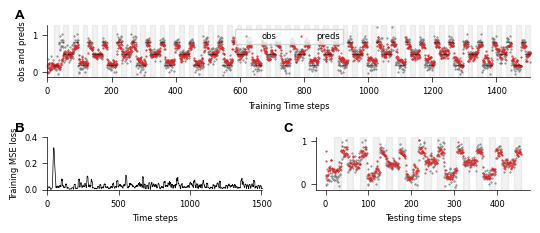

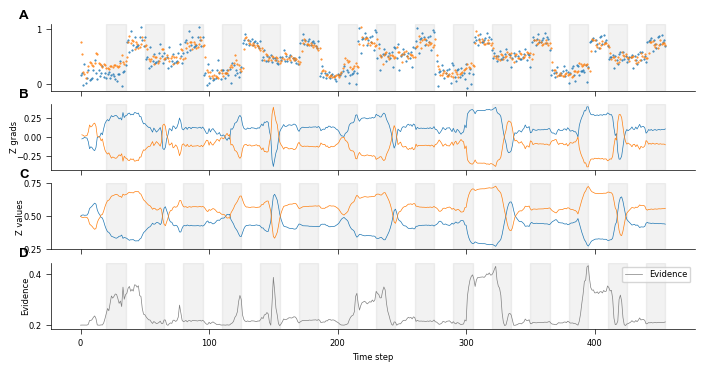

In [43]:
# Train RNN
config = Config()
config.default_std = default_std
scale = 3
training_phase_1_config = {'context_transition_function':'two_sequences',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':30}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=7)
model = LSTM_model(config,hidden_size=100)
weights = [p for n,p in model.named_parameters() if n !='thalamus']
weights = weights + [model.get_parameter('thalamus')]
WU_optimizer = optim.Adam(weights, lr=0.001)
ts_in_training= 0
horizon = training_phase_1_config['max_trials_per_block'] * (1+1+1)

_use_oracle = False
memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
# plot_behavior(memory_buffer, env, losses, config, _use_oracle )


# Testing and plotting
config.training_phases[0]['config']['no_of_blocks'] = 30
testing_env = Generative_environment(config, experiment=7)

# horizon = 5
optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.30, momentum=0.5)
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_oracle = False
_use_optimized_thalamus = False
testing_memory_buffer, testing_losses = adapt_model_v2(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
                                       
plot_behavior_simple(memory_buffer, env, losses, config, _use_oracle, testing_memory_buffer, testing_env)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
# plt.savefig(f'./exports/Cortex_only_CL_behavior.pdf')

In [45]:
# get the obs from the memory buffer
obs = testing_memory_buffer.timestep_data['obs']
obs = np.array(obs)

# get the context from the memory buffer
context = testing_memory_buffer.timestep_data['context_id']
context = np.array(context)


In [50]:
testing_memory_buffer.timestep_data.keys()

dict_keys(['correct_action', 'obs', 'context_oh', 'reward', 'action', 'done', 'obs_augmented', 'context_names', 'context_id', 'trial_i', 'timestep_trial', 'timestep_i', 'thalamus_grad', 'thalamus', 'predictions', 'hidden', 'loss', 'context'])

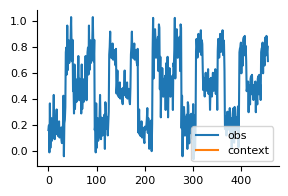

In [49]:
# subplot obs and context
fig, ax = plt.subplots(1,1, figsize=(3,2))
ax.plot(obs.squeeze(), label='obs')
ax.plot(context.squeeze().reshape(-1), label='context') # remove extra dimensions from context array and reshape to match obs
ax.legend()
plt.tight_layout()

# Example analysis
# 
# log.md_context_modulation = np.dot(config.context_vector, mdrates[:,0] )/ np.sum(config.context_vector>0) # normalize by no of trials for each context. Taking MD neuron 0 or 1 should be equal.
# log.md_context_modulation = np.abs(log.md_context_modulation)
# cue_vector = np.ones(np.sum(config.variable_trials_per_block))
# cue_vector[log.Inputs[:,1] == 1] = -1
# log.md_cue_modulation = np.abs( np.dot(cue_vector, mdrates[:,0]/np.sum(cue_vector>0)))


#### Train RNN Cortex+MD  (THe only difference from the above case is Oracle is True)


env_id is larger than thalamus size, setting it to thalamus size-1


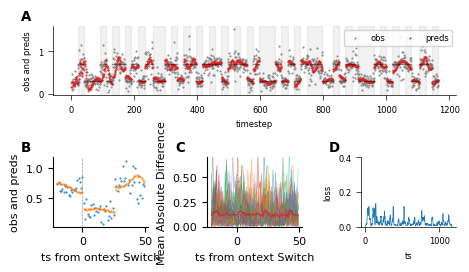

In [8]:
# config = Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},})
config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': 0.1},
                'gauss2': {'mean': default_mean2, 'std': 0.1}, 'gauss3': {'mean': default_mean1, 'std': 0.2},
                 'gauss3': {'mean': default_mean2, 'std': 0.2}}, context_units=2)

scale = 10
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config)
model = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
ts_in_training= 0
horizon = 5

_use_oracle = True
memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
plot_behavior(memory_buffer, env, losses, config, _use_oracle )

env_id is larger than thalamus size, setting it to thalamus size-1


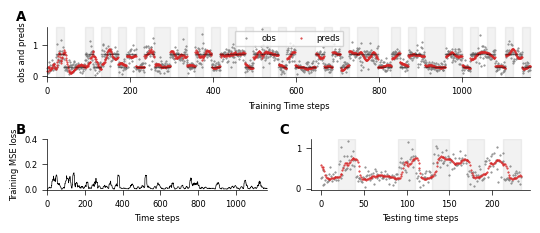

In [9]:
# Testing and plotting
config.training_phases[0]['config']['no_of_blocks'] = 10
testing_env = Generative_environment(config, adapt_env=1)
horizon = 5
optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.30, momentum=0.5)
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_oracle = False
_use_optimized_thalamus = True
testing_memory_buffer, testing_losses = adapt_model_v2(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
                                       
plot_behavior_simple(memory_buffer, env, losses, config, _use_oracle, testing_memory_buffer, testing_env)
# plt.savefig(f'./exports/Cortex_MD_CXT_CL_behavior.pdf')
